# Synthetic control with `pymc` models

In [1]:
import arviz as az

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = cp.load_data("sc")
treatment_time = 70

### {term}`Donor pool selection`

Before fitting, it is good practice to inspect pairwise correlations among units in the pre-treatment period. Negatively correlated donors should be excluded to avoid interpolation bias {cite}`abadie2010synthetic,abadie2021using`.

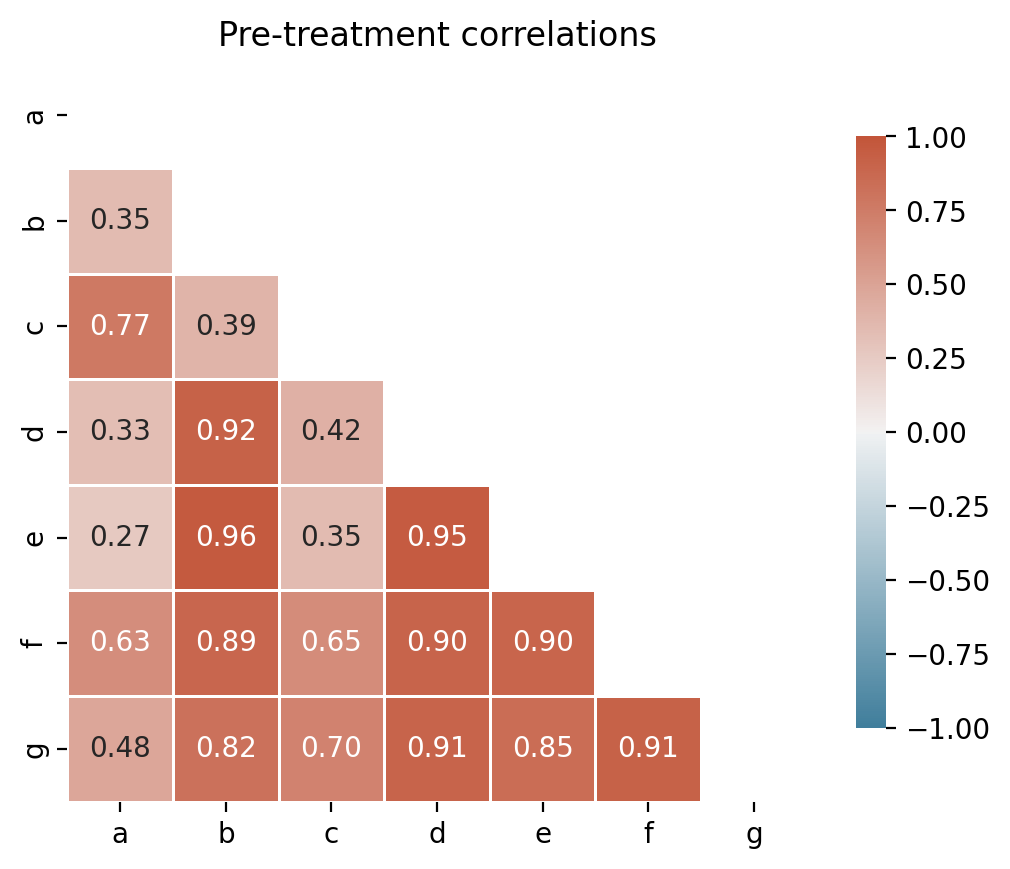

In [4]:
pre = df.loc[:treatment_time]
corr, ax = cp.plot_correlations(pre, columns=["a", "b", "c", "d", "e", "f", "g"])
ax.set(title="Pre-treatment correlations");

All control units are positively correlated with the treated unit (`actual`), so no {term}`donor pool` curation is needed for this dataset. In practice, you would exclude any controls with negative or near-zero correlations.

## Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

### Convex Hull Assumption

The synthetic control method uses non-negative weights that sum to one. This means the synthetic control is a **convex combination** of the control units—it can only produce values within the range spanned by the controls at each time point.

:::{note}
For the method to work well, the treated unit's pre-intervention trajectory should lie within the "envelope" of the control units. If all controls are consistently above or below the treated unit, the method cannot construct an accurate counterfactual.
:::

CausalPy automatically checks this assumption when you create a `SyntheticControl` object and will issue a warning if violated. See the {term}`Convex hull condition` glossary entry and {cite:t}`abadie2010synthetic` for more details. The Augmented Synthetic Control Method {cite:p}`benmichael2021augmented` can handle cases where this assumption is violated.



In [5]:
df.head()

,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,0.793234,1.277264,-0.055407,-0.791535,1.075170,0.817384,-2.607528,0.144888,-0.0,0.398287
1,1.841898,1.185068,-0.221424,-1.430772,1.078303,0.890110,-3.108099,0.601862,-0.0,0.491644
2,2.867102,1.922957,-0.153303,-1.429027,1.432057,1.455499,-3.149104,1.060285,-0.0,1.232330
3,2.816255,2.424558,0.252894,-1.260527,1.938960,2.088586,-3.563201,1.520801,-0.0,1.672995
4,3.865208,2.358650,0.311572,-2.393438,1.977716,2.752152,-3.515991,1.983661,-0.0,1.775940


In [6]:
result = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=["a", "b", "c", "d", "e", "f", "g"],
    treated_units=["actual"],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


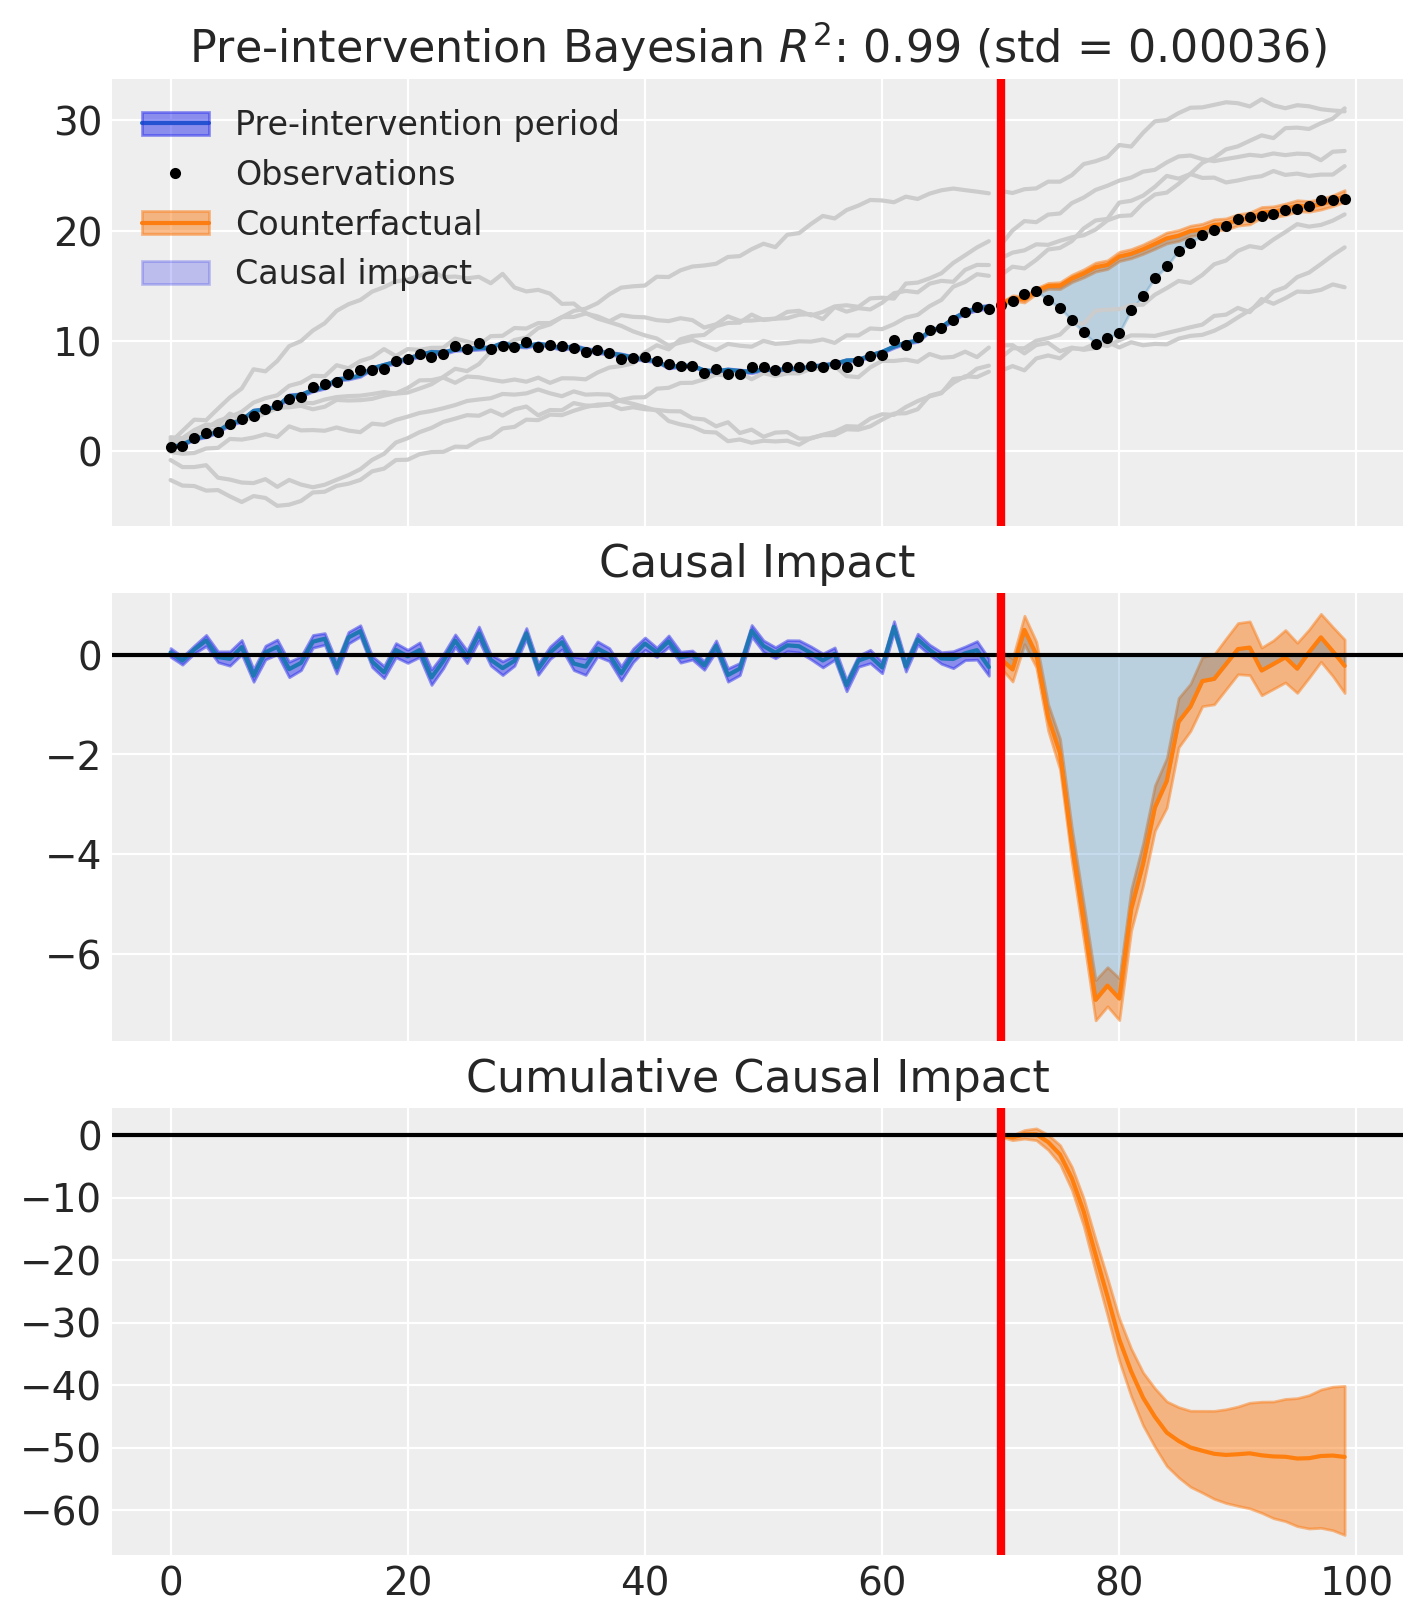

In [7]:
fig, ax = result.plot(plot_predictors=True)

In [8]:
result.summary()

================================SyntheticControl================================
Control units: ['a', 'b', 'c', 'd', 'e', 'f', 'g']
Treated unit: actual
Model coefficients:
    a            0.34, 94% HDI [0.3, 0.38]
    b            0.049, 94% HDI [0.01, 0.089]
    c            0.3, 94% HDI [0.26, 0.35]
    d            0.054, 94% HDI [0.0092, 0.099]
    e            0.026, 94% HDI [0.0015, 0.068]
    f            0.19, 94% HDI [0.1, 0.26]
    g            0.039, 94% HDI [0.0028, 0.09]
    y_hat_sigma  0.26, 94% HDI [0.22, 0.31]
Pre-treatment correlation (actual): 0.9961


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

In [9]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[actual],-1.717,0.216,-2.133,-1.338,0.006,0.003,1260.0,1812.0,1.0


:::{Warning}

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [10]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[actual],-51.498,6.479,-63.982,-40.131,0.182,0.104,1260.0,1812.0,1.0


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect with key statistics. The `effect_summary()` method provides a decision-ready report with average and cumulative effects, HDI intervals, tail probabilities, and relative effects.


In [11]:
# Generate effect summary for the full post-period
stats = result.effect_summary(treated_unit="actual")
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-1.716602,-1.706684,-2.147102,-1.326032,0.0,-9.124018,-11.221693,-7.261266
cumulative,-51.498075,-51.200525,-64.413068,-39.780954,0.0,-9.124018,-11.221693,-7.261266


In [12]:
print(stats.text)

During the post-period (70 to 99), the response variable had an average value of approx. 17.07. By contrast, in the absence of an intervention, we would have expected an average response of 18.79. The 95% interval of this counterfactual prediction is [18.40, 19.22]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is -1.72 with a 95% interval of [-2.15, -1.33].

Summing up the individual data points during the post-period, the response variable had an overall value of 512.18. By contrast, had the intervention not taken place, we would have expected a sum of 563.68. The 95% interval of this prediction is [551.97, 576.60].

The effect is statistically credible: the 95% HDI excludes zero, and the posterior probability of a decrease is 1.000. Relative to the counterfactual, the effect represents a -9.12% change (95% HDI [-11.22%, -7.26%]).

This analysis assumes that the control units u

You can customize the summary in several ways:

- **Window**: Analyze a specific time period instead of the full post-period
- **Direction**: Specify whether you're testing for an increase, decrease, or two-sided effect
- **Options**: Include/exclude cumulative or relative effects


In [13]:
# Example: Analyze first half of post-period
post_indices = result.datapost.index
window_start = post_indices[0]
window_end = post_indices[len(post_indices) // 2]

stats_windowed = result.effect_summary(
    window=(window_start, window_end),
    treated_unit="actual",
    direction="two-sided",
    cumulative=True,
    relative=True,
)

stats_windowed.table

,mean,median,hdi_lower,hdi_upper,p_two_sided,prob_of_effect,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-3.058950,-3.049049,-3.428534,-2.696519,0.0,1.0,-18.641865,-20.446211,-16.814846
cumulative,-48.943206,-48.784789,-54.856540,-43.144308,0.0,1.0,-18.641865,-20.446211,-16.814846


In [14]:
print(stats_windowed.text)

During the post-period (70 to 85), the response variable had an average value of approx. 13.34. By contrast, in the absence of an intervention, we would have expected an average response of 16.40. The 95% interval of this counterfactual prediction is [16.04, 16.77]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is -3.06 with a 95% interval of [-3.43, -2.70].

Summing up the individual data points during the post-period, the response variable had an overall value of 213.44. By contrast, had the intervention not taken place, we would have expected a sum of 262.38. The 95% interval of this prediction is [256.58, 268.30].

The effect is statistically credible: the 95% HDI excludes zero, and the posterior probability of a effect is 1.000. Relative to the counterfactual, the effect represents a -18.64% change (95% HDI [-20.45%, -16.81%]).

This analysis assumes that the control units u

## References
:::{bibliography}
:filter: docname in docnames
:::